# Preliminaries

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
a = torch.zeros(3, device="cuda:0")
import os
from ipywidgets import interact_manual 
from IPython.display import clear_output
import webdataset as wds
from itertools import islice
import ocropus4inf.ocrinf as inf


In [3]:

os.environ["WDS_CACHE"] = "/tmp/ocropus_cache"
os.makedirs(os.environ["WDS_CACHE"], exist_ok=True)

import numpy as np
import scipy.ndimage as ndi
#import display
from IPython.display import display

def ensure_size(image, size=(3000, 3000)):
    # ensure that the image fits into size
    # zoom down if necessary using ndi.zoom
    # do nothing if the image is smaller
    # handle grayscale and color images
    if image.shape[0] > size[0] or image.shape[1] > size[1]:
        zoom = min(size[0] / image.shape[0], size[1] / image.shape[1])
        if image.ndim == 2:
            image = ndi.zoom(image, zoom, order=1)
        else:
            image = ndi.zoom(image, (zoom, zoom, 1), order=1)
    return image



In [4]:

figsize(20, 20)

volumes4 = [f"{i:04d}" for i in range(0, 1000)]
volumes = [f"{i:06d}" for i in range(0, 1000)]
all_pages = [i for i in range(100)]
fontsizes = [4, 6, 8, 10, 12, 14, 18, 24]
preproc_modes = ["none", "binarize", "threshold"]


In [5]:
!gsutil ls gs://ocro-models/v1/seg_unet_v2-*.jit | sort | tail -3

gs://ocro-models/v1/seg_unet_v2-055-000260871.jit
gs://ocro-models/v1/seg_unet_v2-056-000256680.jit
gs://ocro-models/v1/seg_unet_v2-057-000210330.jit


In [6]:
!gsutil ls gs://ocro-models/v1/lstm_resnet_v2-*.jit | sort | tail -3

gs://ocro-models/v1/lstm_resnet_v2-100-000268010.jit
gs://ocro-models/v1/lstm_resnet_v2-101-000161187.jit
gs://ocro-models/v1/lstm_resnet_v2-102-000395585.jit


# Quick OCR Viewer - Internet Archive

Select a shard/page and view OCR results.

In [7]:
textmodel = "https://storage.googleapis.com/ocro-models/v1/lstm_resnet_v2-102-000395585.jit"
segmodel = "https://storage.googleapis.com/ocro-models/v1/seg_unet_v2-057-000210330.jit"
pagerec = inf.PageRecognizer(textmodel=textmodel, segmodel=segmodel, device="cuda:0")

downloading https://storage.googleapis.com/ocro-models/v1/seg_unet_v2-057-000210330.jit to /home/tmb/.cache/ocropus4/seg_unet_v2-057-000210330.jit
loading model /home/tmb/.cache/ocropus4/seg_unet_v2-057-000210330.jit
downloading https://storage.googleapis.com/ocro-models/v1/lstm_resnet_v2-102-000395585.jit to /home/tmb/.cache/ocropus4/lstm_resnet_v2-102-000395585.jit
loading model /home/tmb/.cache/ocropus4/lstm_resnet_v2-102-000395585.jit


**NB: if you are loading a .jit model, the first couple of runs will be much slower.**

In [11]:
@interact_manual(volume=volumes, pageno=all_pages, fontsize=fontsizes, preproc=preproc_modes)
def process_page(volume, pageno=25, fontsize=8, preproc="none"):
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    ds = wds.WebDataset(f"https://storage.googleapis.com/ocro-iaa/segs/books-{volume}-segs.tar").decode("l")
    gray = next(islice(ds, pageno, pageno+1))["jpg"]
    start = time.time()
    results = pagerec.recognize(gray, preproc=preproc)
    ax.set_title(f"{volume} {pageno} ({time.time()-start:.1f}s)")
    pagerec.draw_overlaid(fontsize=fontsize, ax=ax)

interactive(children=(Dropdown(description='volume', options=('000000', '000001', '000002', '000003', '000004'…

# Quick OCR Viewer - Google 1000 Books

interactive(children=(Dropdown(description='volume', index=10, options=('0000', '0001', '0002', '0003', '0004'…

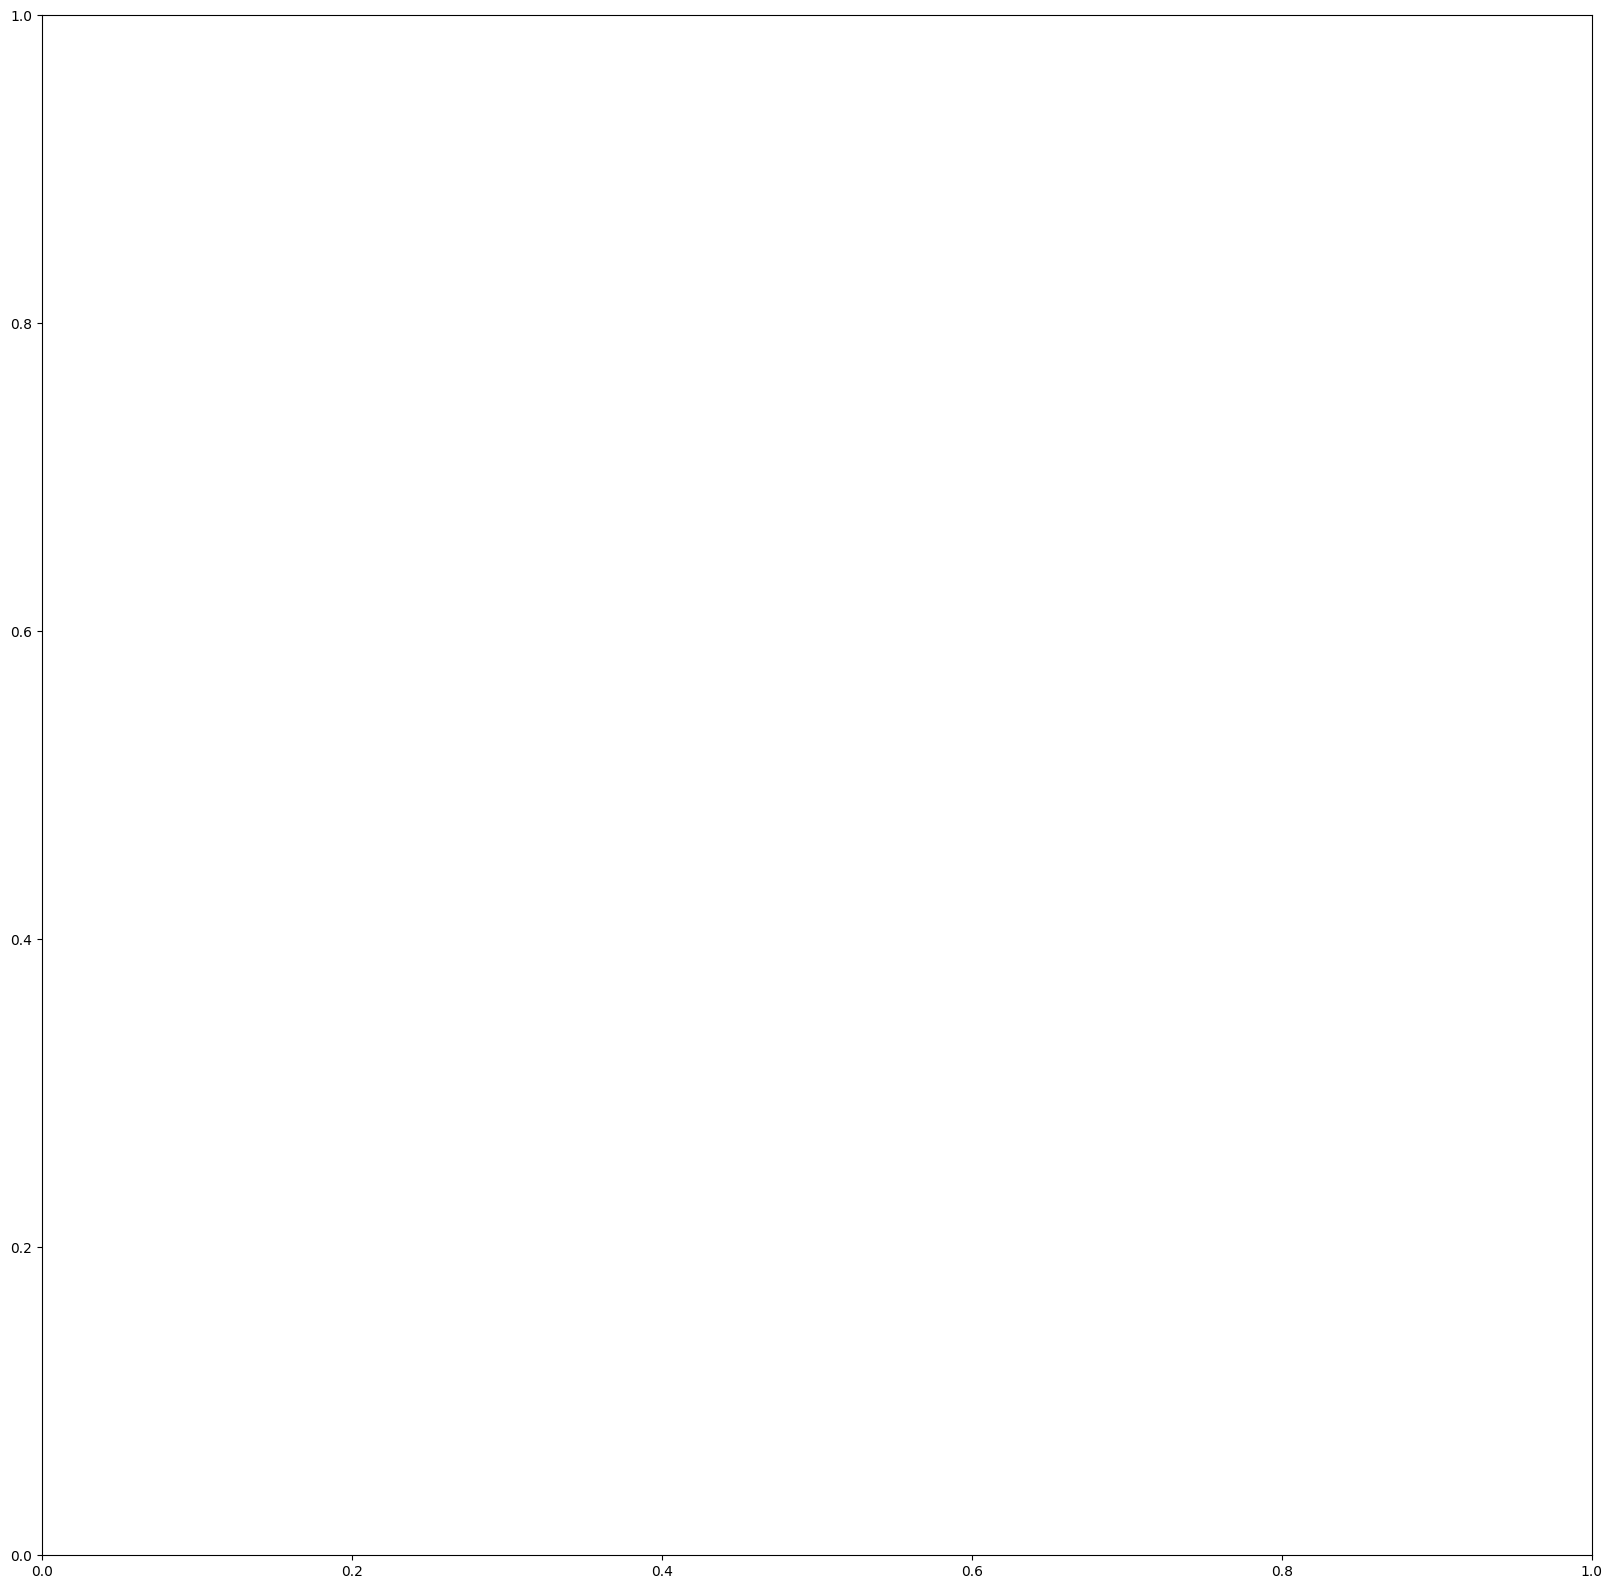

In [9]:
@interact_manual(volume=volumes4, pageno=all_pages, fontsize=fontsizes, preproc=preproc_modes)
def process_page(volume="0010", pageno=25, fontsize=8, preproc="none"):
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    ds = wds.WebDataset(f"https://storage.googleapis.com/ocro-g1000/tess/Volume_{volume}.tgz").decode("l")
    gray = next(islice(ds, pageno, pageno+1))["jpeg"]
    start = time.time()
    results = pagerec.recognize(gray, preproc=preproc)
    ax.set_title(f"{volume} {pageno} ({time.time()-start:.1f}s)")
    pagerec.draw_overlaid(fontsize=fontsize, ax=ax)

# OCR and Segmentation Viewer

This displays the OCR result and the segmentation rsults side-by-side to help with debugging.

In [10]:
attrs = ["seg_probs", "wordmap"]

@interact_manual(volume=volumes, pageno=all_pages, fontsize=fontsizes, preproc=preproc_modes, attr=attrs)
def showseg(volume="000010", pageno=25, fontsize=8, preproc="none", attr="seg_probs"):
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    ds = wds.WebDataset(f"https://storage.googleapis.com/ocro-iaa/segs/books-{volume}-segs.tar").decode("l")
    gray = next(islice(ds, pageno, pageno+1))["jpg"]
    start = time.time()
    results = pagerec.recognize(gray, preproc=preproc)
    axs[0].set_title(f"{volume} {pageno} ({time.time()-start:.1f}s)")
    pagerec.draw_overlaid(fontsize=fontsize, ax=axs[0])
    if attr == "seg_probs":
        axs[1].imshow(pagerec.seg_probs[:,:,1:])
    elif attr == "wordmap":
        inf.show_seg(pagerec.wordmap, ax=axs[1])

interactive(children=(Dropdown(description='volume', index=10, options=('000000', '000001', '000002', '000003'…